In [6]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import json
import pprint
import time
import pandas as p
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Getting Liked Songs and Unliked Songs into Python Dictionaries

In [7]:
username = 'maddytyler'
client_id ='f327bfd79a964a5caddffa4c3dc65709'
client_secret = 'a64342102d5d48379bd0c5b3256acdd2'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-library-read'

token = util.prompt_for_user_token(username,scope,
                                               client_id=client_id,
                                               client_secret=client_secret,
                                               redirect_uri=redirect_uri)

### Given json content, generates a dictionary containing ids and names of each song

In [8]:
def convertJSONToDictionary(jsonContents) :
    songs = []
    for x in range (0, 100) :
        track1 = jsonContents["items"][x]["track"]
        songs.append(track1.get("id"))
    return songs

### Make Calls to Spotify for Liked Songs
Spotify APi only allows to get 100 songs at a time

In [9]:
liked_playlist_id = 'spotify:user:spotifycharts:playlist:1R74kMTnK34RT2Md2O2SP1'
numLikedSongs = 800
sp = spotipy.Spotify(auth=token)
likedSongData = []

for x in range(0, numLikedSongs, 100) :
    if x==0 :
        songList = convertJSONToDictionary(sp.playlist_tracks(liked_playlist_id))
    else:
        songList = convertJSONToDictionary(sp.playlist_tracks(liked_playlist_id, offset=x))
    likedSongData += songList 
    time.sleep(1)

### Making Calls to Spotify for DisLiked Songs

In [10]:
disliked_playlist_id = 'spotify:user:spotifycharts:playlist:5j8Yk0x6O1skW1PEZHz6pE'
numDisLikedSongs = 800
dislikedSongData = []
for x in range(0, numDisLikedSongs, 100) :
    if x==0 :
        songList = convertJSONToDictionary(sp.playlist_tracks(disliked_playlist_id))
    else:
        songList = convertJSONToDictionary(sp.playlist_tracks(disliked_playlist_id, offset=x))
    dislikedSongData += songList
    time.sleep(1)

# Get Song Features and add to Lists
Using the Song IDs gathered previously, we can extract all the audio features for each song

In [11]:
songFeatures = []
for x in range(0, len(likedSongData), 50) :
    features = sp.audio_features(likedSongData[x:(x+50)])
    for song in features :
        songFeatures.append(song)
        songFeatures[-1]["target"] = 1
for y in range(0, len(dislikedSongData), 50) :
    features = sp.audio_features(dislikedSongData[y:(y+50)])
    for song in features :
        songFeatures.append(song)
        songFeatures[-1]["target"] = 0

# Song Features:

### Normalize key, loudness, and tempo features
These are the only values outside of the range 0 - 1 so we normalize them to be within this range

In [12]:
def normalizeValues(sFeatures) :
    keys = []
    loudness = []
    tempo = []
    for x in range(len(sFeatures)):
        keys.append(sFeatures[x]["key"])
        loudness.append(sFeatures[x]["loudness"])
        tempo.append(sFeatures[x]["tempo"])
    kmin, kmax = min(keys), max(keys)
    lmin, lmax = min(loudness), max(loudness)
    tmin, tmax = min(tempo), max(tempo)
    for i, val in enumerate(keys):
        keys[i] = (val-kmin) / (kmax-kmin)
    for j, k in enumerate(loudness):
        loudness[j] = (k-lmin) / (lmax-lmin)
    for l, m in enumerate(tempo):
        tempo[l] = (m-tmin) / (tmax-tmin)
    for x in range(len(sFeatures)):
        sFeatures[x]["key"] = keys[x]
        sFeatures[x]["loudness"] = loudness[x]
        sFeatures[x]["tempo"] = tempo[x]
    return sFeatures

### Normalize values:

In [13]:
songFeatures = normalizeValues(songFeatures)

## Data Table showing all Song Features

In [14]:
trainingData = p.DataFrame(songFeatures) 
trainingData.head(100)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,target
0,0.729,0.662,0.454545,0.784041,0,0.3370,0.001280,0.20800,0.3050,0.359,0.570595,audio_features,1mv4lh1rW1K6xhxhJmEezy,spotify:track:1mv4lh1rW1K6xhxhJmEezy,https://api.spotify.com/v1/tracks/1mv4lh1rW1K6...,https://api.spotify.com/v1/audio-analysis/1mv4...,260907,4,1
1,0.513,0.379,1.000000,0.707290,0,0.0340,0.575000,0.29700,0.0895,0.299,0.390743,audio_features,0wCWiSuGWwdS6DuKws9SOD,spotify:track:0wCWiSuGWwdS6DuKws9SOD,https://api.spotify.com/v1/tracks/0wCWiSuGWwdS...,https://api.spotify.com/v1/audio-analysis/0wCW...,200560,4,1
2,0.414,0.473,1.000000,0.740444,0,0.1160,0.663000,0.05230,0.1280,0.409,0.459605,audio_features,6FBzhcfgGacfXF3AmtfEaX,spotify:track:6FBzhcfgGacfXF3AmtfEaX,https://api.spotify.com/v1/tracks/6FBzhcfgGacf...,https://api.spotify.com/v1/audio-analysis/6FBz...,129698,4,1
3,0.443,0.545,0.000000,0.758567,1,0.0273,0.000813,0.01370,0.2020,0.104,0.459210,audio_features,1Ac5BDsGUMQ3tsW2vnc52x,spotify:track:1Ac5BDsGUMQ3tsW2vnc52x,https://api.spotify.com/v1/tracks/1Ac5BDsGUMQ3...,https://api.spotify.com/v1/audio-analysis/1Ac5...,278640,4,1
4,0.320,0.798,0.909091,0.786906,0,0.1240,0.000330,0.69200,0.1760,0.740,0.389267,audio_features,38wCbVfMreML5ZhF5iQuKA,spotify:track:38wCbVfMreML5ZhF5iQuKA,https://api.spotify.com/v1/tracks/38wCbVfMreML...,https://api.spotify.com/v1/audio-analysis/38wC...,209040,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.581,0.400,0.181818,0.744804,1,0.0291,0.893000,0.57600,0.1610,0.433,0.516279,audio_features,1CLmFKW99S8eJrebO3GB04,spotify:track:1CLmFKW99S8eJrebO3GB04,https://api.spotify.com/v1/tracks/1CLmFKW99S8e...,https://api.spotify.com/v1/audio-analysis/1CLm...,237973,4,1
96,0.555,0.759,0.636364,0.808806,0,0.1420,0.189000,0.45900,0.2480,0.259,0.883692,audio_features,2NfOPrhdkEH7nH9iDXgg7e,spotify:track:2NfOPrhdkEH7nH9iDXgg7e,https://api.spotify.com/v1/tracks/2NfOPrhdkEH7...,https://api.spotify.com/v1/audio-analysis/2NfO...,52006,4,1
97,0.750,0.585,0.818182,0.774283,0,0.0285,0.049000,0.00552,0.1550,0.584,0.470319,audio_features,5mIOsPuQdXchVY0jB5NO9Q,spotify:track:5mIOsPuQdXchVY0jB5NO9Q,https://api.spotify.com/v1/tracks/5mIOsPuQdXch...,https://api.spotify.com/v1/audio-analysis/5mIO...,159595,4,1
98,0.764,0.240,0.000000,0.681689,1,0.1040,0.861000,0.00681,0.1010,0.524,0.349387,audio_features,5fBamKoQ3aXwQpe2Cch8K6,spotify:track:5fBamKoQ3aXwQpe2Cch8K6,https://api.spotify.com/v1/tracks/5fBamKoQ3aXw...,https://api.spotify.com/v1/audio-analysis/5fBa...,148563,4,1


# Visualizing Song Features

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the

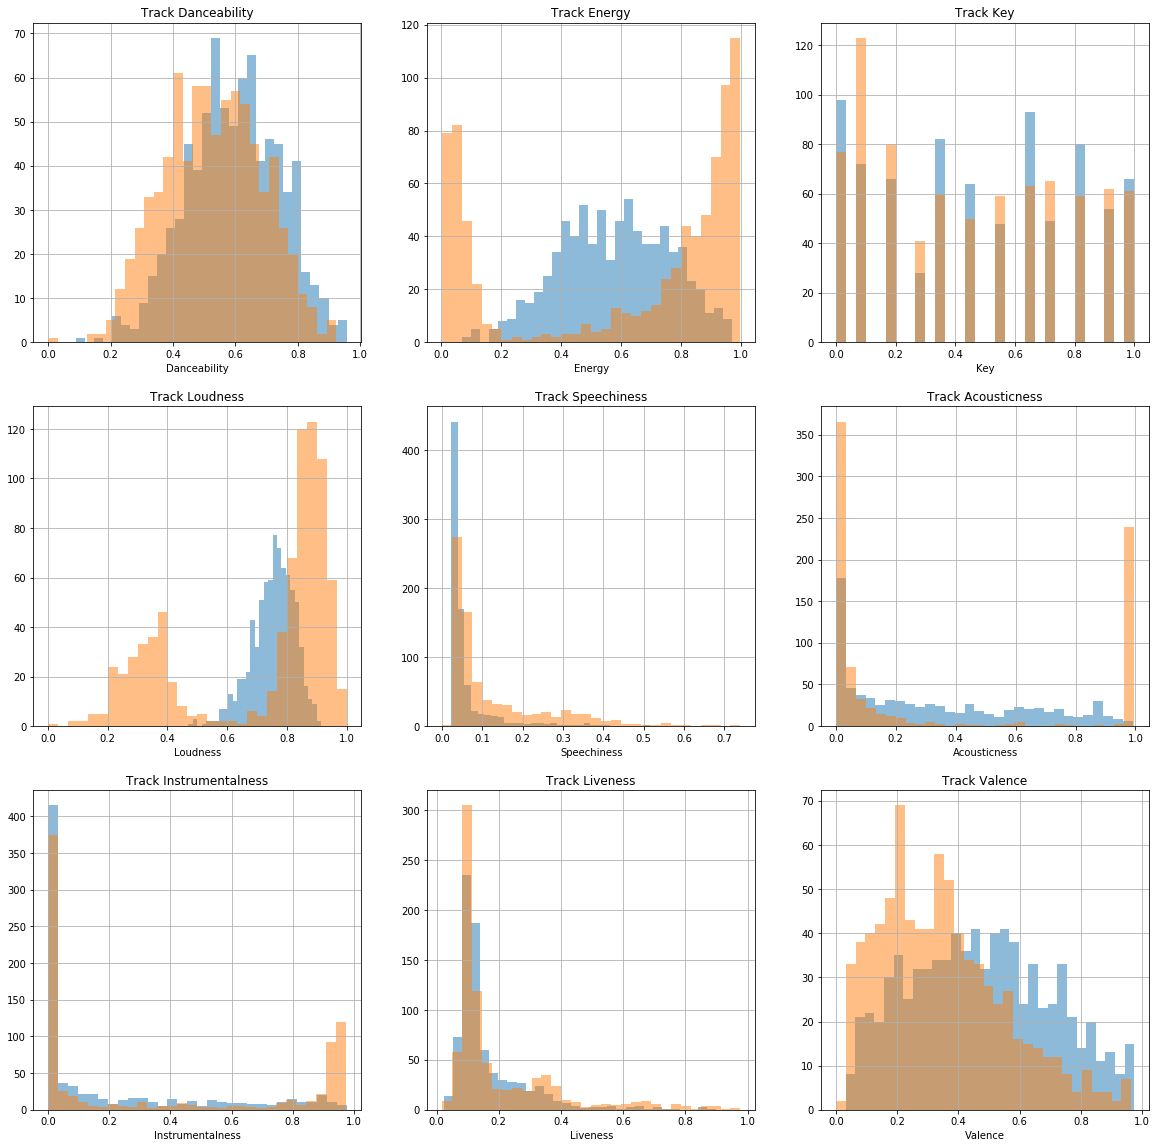

In [15]:
fig1 = plt.figure(figsize=(20,20))

liked_dance = trainingData[trainingData['target'] == 1]['danceability']
disliked_dance = trainingData[trainingData['target'] == 0]['danceability']
ax3 = fig1.add_subplot(331)
ax3.set_xlabel('Danceability')
ax3.set_title('Track Danceability')
liked_dance.hist(alpha= 0.5, bins=30)
ax4 = fig1.add_subplot(331)
disliked_dance.hist(alpha= 0.5, bins=30)

liked_energy = trainingData[trainingData['target'] == 1]['energy']
disliked_energy = trainingData[trainingData['target'] == 0]['energy']
ax5 = fig1.add_subplot(332)
ax5.set_xlabel('Energy')
ax5.set_title('Track Energy')
liked_energy.hist(alpha= 0.5, bins=30)
ax6 = fig1.add_subplot(332)
disliked_energy.hist(alpha= 0.5, bins=30)

liked_key = trainingData[trainingData['target'] == 1]['key']
disliked_key = trainingData[trainingData['target'] == 0]['key']
ax7 = fig1.add_subplot(333)
ax7.set_xlabel('Key')
ax7.set_title('Track Key')
liked_key.hist(alpha= 0.5, bins=30)
ax8 = fig1.add_subplot(333)
disliked_key.hist(alpha= 0.5, bins=30)

liked_loudness = trainingData[trainingData['target'] == 1]['loudness']
disliked_loudness = trainingData[trainingData['target'] == 0]['loudness']
ax9 = fig1.add_subplot(334)
ax9.set_xlabel('Loudness')
ax9.set_title('Track Loudness')
liked_loudness.hist(alpha= 0.5, bins=30)
ax10 = fig1.add_subplot(334)
disliked_loudness.hist(alpha= 0.5, bins=30)

liked_speechiness = trainingData[trainingData['target'] == 1]['speechiness']
disliked_speechiness = trainingData[trainingData['target'] == 0]['speechiness']
ax11 = fig1.add_subplot(335)
ax11.set_xlabel('Speechiness')
ax11.set_title('Track Speechiness')
liked_speechiness.hist(alpha= 0.5, bins=30)
ax12 = fig1.add_subplot(335)
disliked_speechiness.hist(alpha= 0.5, bins=30)

liked_acousticness = trainingData[trainingData['target'] == 1]['acousticness']
disliked_acousticness = trainingData[trainingData['target'] == 0]['acousticness']
ax13 = fig1.add_subplot(336)
ax13.set_xlabel('Acousticness')
ax13.set_title('Track Acousticness')
liked_acousticness.hist(alpha= 0.5, bins=30)
ax14 = fig1.add_subplot(336)
disliked_acousticness.hist(alpha= 0.5, bins=30)

liked_instrumentalness = trainingData[trainingData['target'] == 1]['instrumentalness']
disliked_instrumentalness = trainingData[trainingData['target'] == 0]['instrumentalness']
ax15 = fig1.add_subplot(337)
ax15.set_xlabel('Instrumentalness')
ax15.set_title('Track Instrumentalness')
liked_instrumentalness.hist(alpha= 0.5, bins=30)
ax16 = fig1.add_subplot(337)
disliked_instrumentalness.hist(alpha= 0.5, bins=30)

liked_liveness = trainingData[trainingData['target'] == 1]['liveness']
disliked_liveness = trainingData[trainingData['target'] == 0]['liveness']
ax17 = fig1.add_subplot(338)
ax17.set_xlabel('Liveness')
ax17.set_title('Track Liveness')
liked_liveness.hist(alpha= 0.5, bins=30)
ax18 = fig1.add_subplot(338)
disliked_liveness.hist(alpha= 0.5, bins=30)

liked_valence = trainingData[trainingData['target'] == 1]['valence']
disliked_valence = trainingData[trainingData['target'] == 0]['valence']
ax19 = fig1.add_subplot(339)
ax19.set_xlabel('Valence')
ax19.set_title('Track Valence')
liked_valence.hist(alpha= 0.5, bins=30)
ax20 = fig1.add_subplot(339)
disliked_valence.hist(alpha= 0.5, bins=30)

### Define fetaures we want to use

In [16]:
desiredFeatures = ["danceability", "energy", "key", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo"]

### Split data into testing and training Data

In [17]:
train, test = train_test_split(trainingData, test_size = 0.30)

### Split data into x and y testing and training sets

In [18]:
x_train = train[desiredFeatures]
x_test = test[desiredFeatures]
y_train = keras.utils.to_categorical(train["target"])
y_test = keras.utils.to_categorical(test["target"])

# Now to the Model

In [19]:
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=9))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(2, activation='softmax'))
# Compile the model
model.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=200)

Epoch 1/200
1120/1120 [==============================] - 0s 189us/step - loss: 0.5614 - accuracy: 0.7437
Epoch 2/200
1120/1120 [==============================] - 0s 53us/step - loss: 0.4078 - accuracy: 0.8295
Epoch 3/200
1120/1120 [==============================] - 0s 55us/step - loss: 0.3693 - accuracy: 0.8313
Epoch 4/200
1120/1120 [==============================] - 0s 39us/step - loss: 0.3467 - accuracy: 0.8500
Epoch 5/200
1120/1120 [==============================] - 0s 53us/step - loss: 0.3475 - accuracy: 0.8482
Epoch 6/200
1120/1120 [==============================] - 0s 43us/step - loss: 0.3467 - accuracy: 0.8446
Epoch 7/200
1120/1120 [==============================] - 0s 54us/step - loss: 0.3264 - accuracy: 0.8527
Epoch 8/200
1120/1120 [==============================] - 0s 49us/step - loss: 0.3258 - accuracy: 0.8509
Epoch 9/200
1120/1120 [==============================] - 0s 63us/step - loss: 0.3237 - accuracy: 0.8500
Epoch 10/200
1120/1120 [==============================] - 0s 83

1120/1120 [==============================] - 0s 43us/step - loss: 0.1942 - accuracy: 0.9134
Epoch 80/200
1120/1120 [==============================] - 0s 48us/step - loss: 0.1992 - accuracy: 0.9089
Epoch 81/200
1120/1120 [==============================] - 0s 44us/step - loss: 0.1813 - accuracy: 0.9134
Epoch 82/200
1120/1120 [==============================] - 0s 44us/step - loss: 0.1970 - accuracy: 0.9107
Epoch 83/200
1120/1120 [==============================] - 0s 43us/step - loss: 0.1932 - accuracy: 0.9152
Epoch 84/200
1120/1120 [==============================] - 0s 46us/step - loss: 0.1850 - accuracy: 0.9152
Epoch 85/200
1120/1120 [==============================] - 0s 56us/step - loss: 0.1900 - accuracy: 0.9161
Epoch 86/200
1120/1120 [==============================] - 0s 58us/step - loss: 0.1802 - accuracy: 0.9187
Epoch 87/200
1120/1120 [==============================] - 0s 45us/step - loss: 0.1881 - accuracy: 0.9161
Epoch 88/200
1120/1120 [==============================] - 0s 45us/st

1120/1120 [==============================] - 0s 57us/step - loss: 0.0796 - accuracy: 0.9670
Epoch 157/200
1120/1120 [==============================] - 0s 55us/step - loss: 0.0763 - accuracy: 0.9732
Epoch 158/200
1120/1120 [==============================] - 0s 58us/step - loss: 0.0871 - accuracy: 0.9670
Epoch 159/200
1120/1120 [==============================] - 0s 62us/step - loss: 0.1048 - accuracy: 0.9571
Epoch 160/200
1120/1120 [==============================] - 0s 53us/step - loss: 0.0783 - accuracy: 0.9679
Epoch 161/200
1120/1120 [==============================] - 0s 47us/step - loss: 0.1070 - accuracy: 0.9696
Epoch 162/200
1120/1120 [==============================] - 0s 37us/step - loss: 0.0683 - accuracy: 0.9714
Epoch 163/200
1120/1120 [==============================] - 0s 35us/step - loss: 0.0810 - accuracy: 0.9625
Epoch 164/200
1120/1120 [==============================] - 0s 37us/step - loss: 0.0763 - accuracy: 0.9741
Epoch 165/200
1120/1120 [==============================] - 0

In [20]:
#predicts the training data
pred_train= model.predict(x_train) 
#evaluates the model
trainingScores = model.evaluate(x_train, y_train, verbose=0)
#prints the accuracy and error on the training data
print('Accuracy on training data: {}% \n Error on training data: {}'.format(trainingScores[1], 1 - trainingScores[1]))
#predicts the testing data
pred_test= model.predict(x_test)

#evaluates the model
testingScores = model.evaluate(x_test, y_test, verbose=0)
#prints the accuracy and error on the testing data
print('Accuracy on testing data: {}% \n Error on testing data: {}'.format(testingScores[1], 1 - testingScores[1]))

Accuracy on training data: 0.9919642806053162% 
 Error on training data: 0.008035719394683838
Accuracy on testing data: 0.8770833611488342% 
 Error on testing data: 0.12291663885116577


# Now to find some new songs!

### Spotify "New Music Friday Playlist"

In [21]:
playlistToSearch = sp.user_playlist("spotify", "7dUFBY0mmJgN4hLSyqHxpm")
tracks = playlistToSearch["tracks"]
songs = tracks["items"] 
songIDs = [] 
newFeatures = []
count = 0

while tracks['next']:
    tracks = sp.next(tracks)
    for song in tracks["items"]:
        songs.append(song)
#get song IDs
for i in range(len(songs)):
    songIDs.append(songs[i]['track']['id'])
#get song features
for i in range(0,len(songIDs),50):
    features = sp.audio_features(songIDs[i:i+50])
    for track in features:
        track['song_title'] = songs[count]['track']['name']
        track['artist'] = songs[count]['track']['artists'][0]['name']
        count+= 1
        newFeatures.append(track)
#normalize values
newFeatures = normalizeValues(newFeatures)
#new data table
newData = p.DataFrame(newFeatures)
newData.head(100)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,song_title,artist
0,0.825,0.373,0.454545,0.767527,0,0.1080,0.16300,0.000000,0.3680,0.120,0.035614,audio_features,6Kj17Afjo1OKJYpf5VzCeo,spotify:track:6Kj17Afjo1OKJYpf5VzCeo,https://api.spotify.com/v1/tracks/6Kj17Afjo1OK...,https://api.spotify.com/v1/audio-analysis/6Kj1...,149078,4,Pain 1993 (with Playboi Carti),Drake
1,0.630,0.633,0.363636,0.620901,1,0.0457,0.00776,0.000000,0.0541,0.452,0.161006,audio_features,3Z8FwOEN59mRMxDCtb8N0A,spotify:track:3Z8FwOEN59mRMxDCtb8N0A,https://api.spotify.com/v1/tracks/3Z8FwOEN59mR...,https://api.spotify.com/v1/audio-analysis/3Z8F...,172762,4,Be Kind (with Halsey),Marshmello
2,0.822,0.743,0.909091,0.839144,0,0.2800,0.01600,0.000000,0.1270,0.636,0.089508,audio_features,5v4GgrXPMghOnBBLmveLac,spotify:track:5v4GgrXPMghOnBBLmveLac,https://api.spotify.com/v1/tracks/5v4GgrXPMghO...,https://api.spotify.com/v1/audio-analysis/5v4G...,242001,4,Savage Remix (feat. Beyoncé),Megan Thee Stallion
3,0.926,0.542,0.090909,0.811628,1,0.2930,0.13500,0.000000,0.0877,0.564,0.469499,audio_features,6gxKUmycQX7uyMwJcweFjp,spotify:track:6gxKUmycQX7uyMwJcweFjp,https://api.spotify.com/v1/tracks/6gxKUmycQX7u...,https://api.spotify.com/v1/audio-analysis/6gxK...,181929,4,We Paid (feat. 42 Dugg),Lil Baby
4,0.718,0.706,0.090909,0.750848,1,0.0600,0.01280,0.000000,0.3520,0.815,0.730900,audio_features,5fHrHoJKfCgBd35zwIBmUK,spotify:track:5fHrHoJKfCgBd35zwIBmUK,https://api.spotify.com/v1/tracks/5fHrHoJKfCgB...,https://api.spotify.com/v1/audio-analysis/5fHr...,189176,4,D4L,Future
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.735,0.500,0.636364,0.775631,1,0.0322,0.30100,0.025400,0.0827,0.316,0.378305,audio_features,0De46EQMJnoOunDixVAwf2,spotify:track:0De46EQMJnoOunDixVAwf2,https://api.spotify.com/v1/tracks/0De46EQMJnoO...,https://api.spotify.com/v1/audio-analysis/0De4...,234201,4,THE TRADE,Jak Bannon
95,0.479,0.540,0.000000,0.542782,0,0.3100,0.69900,0.000766,0.1700,0.470,0.758641,audio_features,7cgrzmkoIn4t0bMQ5NoatW,spotify:track:7cgrzmkoIn4t0bMQ5NoatW,https://api.spotify.com/v1/tracks/7cgrzmkoIn4t...,https://api.spotify.com/v1/audio-analysis/7cgr...,244800,4,I Never Stay In Love,Stephen
96,0.746,0.439,0.454545,0.262439,0,0.2580,0.01650,0.000830,0.0845,0.218,0.159926,audio_features,3eN0UdI8lunnq9vAsRu3m5,spotify:track:3eN0UdI8lunnq9vAsRu3m5,https://api.spotify.com/v1/tracks/3eN0UdI8lunn...,https://api.spotify.com/v1/audio-analysis/3eN0...,139850,5,Nonbinary,Arca
97,0.876,0.868,0.000000,0.823879,0,0.1960,0.00548,0.000000,0.0591,0.804,0.625789,audio_features,2fVtXxKKnGzwWUeZXlZiaf,spotify:track:2fVtXxKKnGzwWUeZXlZiaf,https://api.spotify.com/v1/tracks/2fVtXxKKnGzw...,https://api.spotify.com/v1/audio-analysis/2fVt...,136881,4,Replacements,ADÉ


In [28]:
x_new = newData[desiredFeatures]
pred_reccomendations= model.predict(x_new)
numLiked = 0
counter = 0

for prediction in pred_reccomendations:
    if(prediction[0] < prediction[1]):
        print ((numLiked+1),". Liked Song: " + newData["song_title"][counter] + ", By: "+ newData["artist"][counter])
        numLiked+= 1
    counter+=1

1 . Liked Song: Be Kind (with Halsey), By: Marshmello
2 . Liked Song: D4L, By: Future
3 . Liked Song: Moana, By: G-Eazy
4 . Liked Song: I Know Alone, By: HAIM
5 . Liked Song: HEART ATTACK (feat. lau.ra), By: BRONSON
6 . Liked Song: Unbelievable (feat. Kaash Paige), By: 24kGoldn
7 . Liked Song: F&MU, By: Kehlani
8 . Liked Song: Say So, By: Doja Cat
9 . Liked Song: Wrong Places (from Songland), By: H.E.R.
10 . Liked Song: Dreamland, By: Glass Animals
11 . Liked Song: Bloody Valentine, By: Machine Gun Kelly
12 . Liked Song: Ice Cold, By: Lil Tjay
13 . Liked Song: Viral Moment, By: Lil Durk
14 . Liked Song: Circles - Recorded at Electric Lady Studios NYC, 2020, By: Dashboard Confessional
15 . Liked Song: Friends (feat. Powfu), By: Mishaal
16 . Liked Song: Comeback (feat. Tory Lanez and 30 Roc), By: JoJo
17 . Liked Song: Kevin, By: Oliver Malcolm
18 . Liked Song: bummy!, By: boylife
19 . Liked Song: realtree, By: boyband
20 . Liked Song: Coffee, By: Quinn XCII
21 . Liked Song: Happy Does, B